## Introduction

Dans ce notebook, nous avons pour objectif de réaliser un travail de feature engineering sur nos données immobilières à l'échelle de la ville. Ce processus vise à enrichir notre jeu de données tout en évitant le *data leakage*. Plus précisément, nous allons :

- **Recalculer les indicateurs clés**  
  Afin d'éviter le data leakage, nous supprimerons les variables `prix_m2_mois` et `nb_transactions_mois` et les remplacerons par leurs équivalents calculés sur le **mois précédent**.

- **Calculer des moyennes glissantes**  
  Pour les deux indicateurs recalculés (prix au m² et nombre de transactions), nous déterminerons également la moyenne glissante sur les 6 mois précédents. Cela permettra de lisser les variations mensuelles et de mieux saisir les tendances.

- **Ajouter une nouvelle feature : "ville demandée"**  
  Cette feature indiquera si une ville se trouve dans le quantile 0.8 (au-dessus du seuil) en termes de nombre de transactions mensuelles à l'échelle du département.

- **Analyser la matrice de corrélation**  
  Nous examinerons la matrice de corrélation pour identifier les relations fortes (corrélation > 0.7) entre les variables et choisir lesquelles conserver

Ces transformations et analyses nous conduiront à la prochaine étape : l'implémentation de la fonction `feature_engineering.py`, qui automatisera ces processus dans notre pipeline de traitement de données.

# Importation des librairies

In [4]:
import os
import sys

sys.path.append("..")

# Basic Libraries
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
# Visualization Libraries

import matplotlib.pyplot as plt
import seaborn as sns


from settings import (
    PROJECT_PATH,
    REGRESSION_TARGET, CLASSIFICATION_TARGET)

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Importation du fichier

In [6]:
table= pq.read_table(os.path.join(PROJECT_PATH,'data/raw/transactions_immobilieres.parquet'))
# Convertir en DataFrame Pandas
data = table.to_pandas()

data.head()

,id_transaction,date_transaction,prix,departement,id_ville,ville,code_postal,adresse,type_batiment,vefa,...,annee_transaction,prix_m2,prix_m2_moyen,nb_transactions_mois,en_dessous_du_marche,code_departement,nom_departement,code_region,nom_region,region
0,83094,2018-01-03,98000.0,1,53,BOURG-EN-BRESSE,1000,8 RUE TRAVERSIERE,Appartement,0,...,2018,1400.000000,1229.764459,17,0,01,Ain,84,Auvergne-Rhône-Alpes,84
1,70798,2018-01-04,225000.0,1,143,DIVONNE-LES-BAINS,1220,62 RUE VOLTAIRE,Appartement,0,...,2018,4017.857143,4512.419826,9,1,01,Ain,84,Auvergne-Rhône-Alpes,84
2,77488,2018-01-04,67000.0,1,53,BOURG-EN-BRESSE,1000,12 ALL DE LA PETITE REYSSOUZE,Appartement,0,...,2018,1488.888889,1229.764459,17,0,01,Ain,84,Auvergne-Rhône-Alpes,84
3,78665,2018-01-05,503000.0,1,143,DIVONNE-LES-BAINS,1220,48 RUE DE LA SCIE,Appartement,0,...,2018,6134.146341,4512.419826,9,0,01,Ain,84,Auvergne-Rhône-Alpes,84
4,72218,2018-01-05,339000.0,1,143,DIVONNE-LES-BAINS,1220,151 CHE DE LA CREUSE,Appartement,0,...,2018,4985.294118,4512.419826,9,0,01,Ain,84,Auvergne-Rhône-Alpes,84


In [8]:
df= data.copy()

In [9]:
df.shape

(529460, 26)

# Feature Enginering sur la localisation

In [25]:
# regrouper par ville
df_city = df.groupby(['nom_departement','ville','id_ville','annee_transaction', 'mois_transaction',
                           'nb_transactions_mois'] ).agg(prix_m2_moyen=('prix_m2_moyen', 'mean')).round(2).reset_index()


df_city

,nom_departement,ville,id_ville,annee_transaction,mois_transaction,nb_transactions_mois,prix_m2_moyen
0,Ain,AMBERIEU-EN-BUGEY,4,2019,7,5,1488.16
1,Ain,AMBERIEU-EN-BUGEY,4,2019,10,8,1742.17
2,Ain,AMBERIEU-EN-BUGEY,4,2019,12,8,1525.69
3,Ain,AMBERIEU-EN-BUGEY,4,2020,2,5,1662.49
4,Ain,AMBERIEU-EN-BUGEY,4,2020,11,5,1757.71
...,...,...,...,...,...,...,...
24484,Yvelines,VIROFLAY,686,2021,4,8,5786.16
24485,Yvelines,VIROFLAY,686,2021,5,10,5881.62
24486,Yvelines,VIROFLAY,686,2021,6,6,5277.27
24487,Yvelines,VIROFLAY,686,2021,10,5,6300.86


### Recherche des villes en tension

In [11]:
def compute_city_features(
    transaction_per_city: pd.DataFrame,
    aggregation_columns: list = ['nom_departement', 'ville','id_ville', 'annee_transaction', 'mois_transaction', 'nb_transactions_mois'],
    threshold: float = 0.8
):
    """
    Cette fonction calcule plusieurs caractéristiques liées aux transactions immobilières par ville.

    1. Elle agrège les données de transactions par ville et mois pour obtenir le prix moyen au m2.
    2. Elle calcule le ratio des transactions de chaque ville par rapport au département.
    3. Elle applique un seuil basé sur le quantile spécifié pour identifier les villes en tension.

    Paramètres :
    -----------
    transaction_per_city : pd.DataFrame
        Un DataFrame contenant les informations des transactions immobilières, y compris le prix au m2,
        le nombre de transactions, ainsi que des colonnes de regroupement par département, ville et mois.

    aggregation_columns : list, optionnel
        Liste des colonnes utilisées pour l'agrégation des données (par défaut : ['nom_departement', 'ville', 'annee_transaction', 'mois_transaction', 'nb_transactions_mois']).

    threshold : float, optionnel
        Quantile (par défaut à 0.8) utilisé pour déterminer le seuil au-dessus duquel une ville est considérée en tension.

    Retour :
    --------
    pd.DataFrame
        Un DataFrame enrichi avec :
        - `prix_m2_moyen` : Prix moyen au m2 par ville et mois,
        - `ratio_transaction` : Ratio des transactions de la ville par rapport au département,
        - `ville_demandee` : Indicateur binaire indiquant si la ville est en tension (1 si en tension, 0 sinon).
    """

    # Agréger les données par ville, année, mois et nombre de transactions
    transaction_per_city = transaction_per_city.groupby(aggregation_columns).agg(prix_m2_moyen=('prix_m2_moyen', 'mean')).reset_index()

    # Calculer le nombre total de transactions par département et par mois
    nb_transactions_departement = transaction_per_city.groupby(['nom_departement', 'annee_transaction', 'mois_transaction'])['nb_transactions_mois'].sum().reset_index().rename(columns={'nb_transactions_mois': 'nb_transactions_departement'})

    # Fusionner les données pour avoir le nombre total de transactions par département pour chaque ligne de ville
    transaction_per_city = transaction_per_city.merge(nb_transactions_departement, on=['nom_departement', 'annee_transaction', 'mois_transaction'], how='outer')

    # Calculer le ratio des transactions de la ville par rapport au département
    transaction_per_city['ratio_transaction'] = (transaction_per_city['nb_transactions_mois'] / transaction_per_city['nb_transactions_departement']) * 100

    # Déterminer le seuil de tension en fonction du quantile spécifié
    seuil_tension = transaction_per_city['ratio_transaction'].quantile(threshold)

    # Appliquer un indicateur binaire pour savoir si la ville est en tension
    transaction_per_city['ville_demandee'] = transaction_per_city['ratio_transaction'].apply(lambda x: 1 if x > seuil_tension else 0)

    return transaction_per_city



In [26]:
df_city=compute_city_features (
    transaction_per_city = df_city,
    aggregation_columns = ['nom_departement','ville','id_ville','annee_transaction', 'mois_transaction',
                           'nb_transactions_mois'],
    threshold =0.8
)

In [27]:
df_city['ville_demandee'].describe()

count    24489.000000
mean         0.200008
std          0.400014
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: ville_demandee, dtype: float64

### Lagging pour eviter le data leakage

In [14]:
def compute_features_price_per_m2(
    average_per_month_per_city: pd.DataFrame,
    sort_columns: list = [
        "nom_departement",
        "ville",
        'id_ville',
        "annee_transaction",
        "mois_transaction"
    ],
    aggregation_columns: list = [
        "nom_departement",
        "ville",
        "id_ville",
    ],
    aggregation_months: int = 6
):
    """
    Cette fonction calcule des caractéristiques dérivées pour les prix au m² et le nombre de transactions
    pour chaque ville et département, avec des moyennes mobiles et des valeurs précédentes.

    Paramètres:
    - average_per_month_per_city (pd.DataFrame): DataFrame contenant les données des prix au m²
      et des transactions par mois et ville.
    - sort_columns (list, optionnel): Liste des colonnes par lesquelles trier les données avant de
      calculer les caractéristiques dérivées. Par défaut, cela inclut "nom_departement", "ville", "annee_transaction",
      et "mois_transaction".
    - aggregation_columns (list, optionnel): Colonnes utilisées pour le groupby. Par défaut, cela inclut
      "nom_departement", "ville" et "id_ville".
    - aggregation_months (int, optionnel): Nombre de mois pour la moyenne mobile glissante. Par défaut, c'est 6.

    Retour:
    - pd.DataFrame: DataFrame avec les nouvelles caractéristiques dérivées, incluant les prix et
      le nombre de transactions des mois précédents, ainsi que les moyennes mobiles.

    Processus:
    1. Trie les données selon les colonnes spécifiées.
    2. Calcule les prix au m² et le nombre de transactions des mois précédents pour chaque groupe.
    3. Calcule les moyennes mobiles glissantes pour les prix au m² et les transactions.
    4. Supprime les lignes contenant des valeurs manquantes (NaN).
    5. Renomme la colonne de la moyenne mobile pour refléter le nombre de mois utilisé.
    """

    # Trier les données selon les colonnes spécifiées
    average_per_month_per_city = average_per_month_per_city.sort_values(by=sort_columns)

    # Calculer les colonnes dérivées pour le mois précédent (shift)
    average_per_month_per_city["prix_m2_moyen_mois_precedent"] = (
        average_per_month_per_city.groupby(aggregation_columns)["prix_m2_moyen"]
        .shift()
    )
    average_per_month_per_city["nb_transactions_mois_precedent"] = (
        average_per_month_per_city.groupby(aggregation_columns)['nb_transactions_mois']
        .shift()
    )

    # Calculer les moyennes mobiles glissantes sur 'aggregation_months' mois
    average_per_month_per_city["prix_m2_moyen_glissant"] = (
        average_per_month_per_city.groupby(aggregation_columns)["prix_m2_moyen"]
        .transform(lambda x: x.rolling(window=aggregation_months).mean())
    )
    average_per_month_per_city["nb_transaction_moyen_glissant"] = (
        average_per_month_per_city.groupby(aggregation_columns)['nb_transactions_mois']
        .transform(lambda x: x.rolling(window=aggregation_months).mean())
    )

    # Renommer la colonne de moyenne mobile pour refléter le nombre de mois dans la moyenne glissante
    average_per_month_per_city = average_per_month_per_city.rename(
        columns={
            "nb_transaction_moyen_glissant": f"nb_transaction_moyen_glissant_{aggregation_months}m",
            "prix_m2_moyen_glissant": f"prix_m2_moyen_glissant_{aggregation_months}m"
        }
    )

    # Supprimer les NaN engendrés par les opérations de shift et de rolling
    average_per_month_per_city = average_per_month_per_city.dropna()

    # Retourner le DataFrame avec les nouvelles caractéristiques calculées
    return average_per_month_per_city

In [28]:
df_city_agg = compute_features_price_per_m2(
    df_city,
    sort_columns=[
        "nom_departement",
        "ville",
        'id_ville',
        "annee_transaction",
        "mois_transaction",
    ],
    aggregation_columns=[
        "nom_departement",
        "ville",
        'id_ville'
    ],
    aggregation_months=6)

In [29]:

# Joindre les nouvelles colonnes au DataFrame d'origine (df_city)
transactions = df.merge(df_city_agg[['nom_departement', 'ville', 'id_ville', 'annee_transaction', 'mois_transaction',
                                      'prix_m2_moyen_mois_precedent', 'nb_transactions_mois_precedent',
                                      'prix_m2_moyen_glissant_6m', 'nb_transaction_moyen_glissant_6m',"ville_demandee"]],
                        on=['nom_departement', 'ville', 'id_ville', 'annee_transaction', 'mois_transaction'],
                        how='inner')




In [30]:
# Vérifier le résultat
transactions.head()

,id_transaction,date_transaction,prix,departement,id_ville,ville,code_postal,adresse,type_batiment,vefa,...,code_departement,nom_departement,code_region,nom_region,region,prix_m2_moyen_mois_precedent,nb_transactions_mois_precedent,prix_m2_moyen_glissant_6m,nb_transaction_moyen_glissant_6m,ville_demandee
0,71841,2018-06-01,30000.0,1,53,BOURG-EN-BRESSE,1000,1 RUE ALFRED BERTHOLET,Appartement,0,...,01,Ain,84,Auvergne-Rhône-Alpes,84,1241.19,11.0,1243.101667,16.666667,1
1,80792,2018-06-01,73000.0,1,53,BOURG-EN-BRESSE,1000,24 RUE DE CUIRON,Appartement,0,...,01,Ain,84,Auvergne-Rhône-Alpes,84,1241.19,11.0,1243.101667,16.666667,1
2,81597,2018-06-04,185000.0,1,53,BOURG-EN-BRESSE,1000,11 RUE DE SAVOIE,Maison,0,...,01,Ain,84,Auvergne-Rhône-Alpes,84,1241.19,11.0,1243.101667,16.666667,1
3,84295,2018-06-05,65000.0,1,53,BOURG-EN-BRESSE,1000,68 AV DE MACON,Appartement,0,...,01,Ain,84,Auvergne-Rhône-Alpes,84,1241.19,11.0,1243.101667,16.666667,1
4,75384,2018-06-08,84000.0,1,53,BOURG-EN-BRESSE,1000,7 RUE HENRI DUNANT,Appartement,0,...,01,Ain,84,Auvergne-Rhône-Alpes,84,1241.19,11.0,1243.101667,16.666667,1


In [31]:
transactions.shape

(468115, 31)

## Analyse des corrélations entre features numériques

In [19]:
transactions.columns

Index(['id_transaction', 'date_transaction', 'prix', 'departement', 'id_ville',
       'ville', 'code_postal', 'adresse', 'type_batiment', 'vefa', 'n_pieces',
       'surface_habitable', 'id_parcelle_cadastre', 'latitude', 'longitude',
       'mois_transaction', 'annee_transaction', 'prix_m2', 'prix_m2_moyen',
       'nb_transactions_mois', 'en_dessous_du_marche', 'code_departement',
       'nom_departement', 'code_region', 'nom_region', 'region',
       'prix_m2_moyen_mois_precedent', 'nb_transactions_mois_precedent',
       'prix_m2_moyen_glissant_6m', 'nb_transaction_moyen_glissant_6m',
       'ville_demandee'],
      dtype='object')

In [20]:
# colonnes à laisser de côté
cols_extra_info = ['id_transaction', 'date_transaction', 'id_ville', 'ville',
                   'code_departement', 'departement', 'code_region', 'region',
                   'adresse', 'code_postal', 'id_parcelle_cadastre',
                   'prix_m2', 'prix_m2_moyen', 'nom_departement','nb_transactions_mois']


In [32]:
transactions=transactions.drop(cols_extra_info,axis=1)
transactions.head()

,prix,type_batiment,vefa,n_pieces,surface_habitable,latitude,longitude,mois_transaction,annee_transaction,en_dessous_du_marche,nom_region,prix_m2_moyen_mois_precedent,nb_transactions_mois_precedent,prix_m2_moyen_glissant_6m,nb_transaction_moyen_glissant_6m,ville_demandee
0,30000.0,Appartement,0,1,34,46.210785,5.228714,6,2018,1,Auvergne-Rhône-Alpes,1241.19,11.0,1243.101667,16.666667,1
1,73000.0,Appartement,0,4,77,46.190439,5.238234,6,2018,1,Auvergne-Rhône-Alpes,1241.19,11.0,1243.101667,16.666667,1
2,185000.0,Maison,0,5,107,46.196411,5.274976,6,2018,0,Auvergne-Rhône-Alpes,1241.19,11.0,1243.101667,16.666667,1
3,65000.0,Appartement,0,3,65,46.211106,5.219147,6,2018,1,Auvergne-Rhône-Alpes,1241.19,11.0,1243.101667,16.666667,1
4,84000.0,Appartement,0,4,86,46.213257,5.228674,6,2018,1,Auvergne-Rhône-Alpes,1241.19,11.0,1243.101667,16.666667,1


In [22]:
features_name =  transactions.columns
features_name

Index(['prix', 'type_batiment', 'vefa', 'n_pieces', 'surface_habitable',
       'latitude', 'longitude', 'mois_transaction', 'annee_transaction',
       'en_dessous_du_marche', 'nom_region', 'prix_m2_moyen_mois_precedent',
       'nb_transactions_mois_precedent', 'prix_m2_moyen_glissant_6m',
       'nb_transaction_moyen_glissant_6m', 'ville_demandee'],
      dtype='object')

In [23]:
numerical_features = [col for col in transactions[features_name].select_dtypes(include={'float', 'integer'})  if transactions[col].nunique() > 2]

numerical_features

['prix',
 'n_pieces',
 'surface_habitable',
 'latitude',
 'longitude',
 'mois_transaction',
 'annee_transaction',
 'prix_m2_moyen_mois_precedent',
 'nb_transactions_mois_precedent',
 'prix_m2_moyen_glissant_6m',
 'nb_transaction_moyen_glissant_6m']

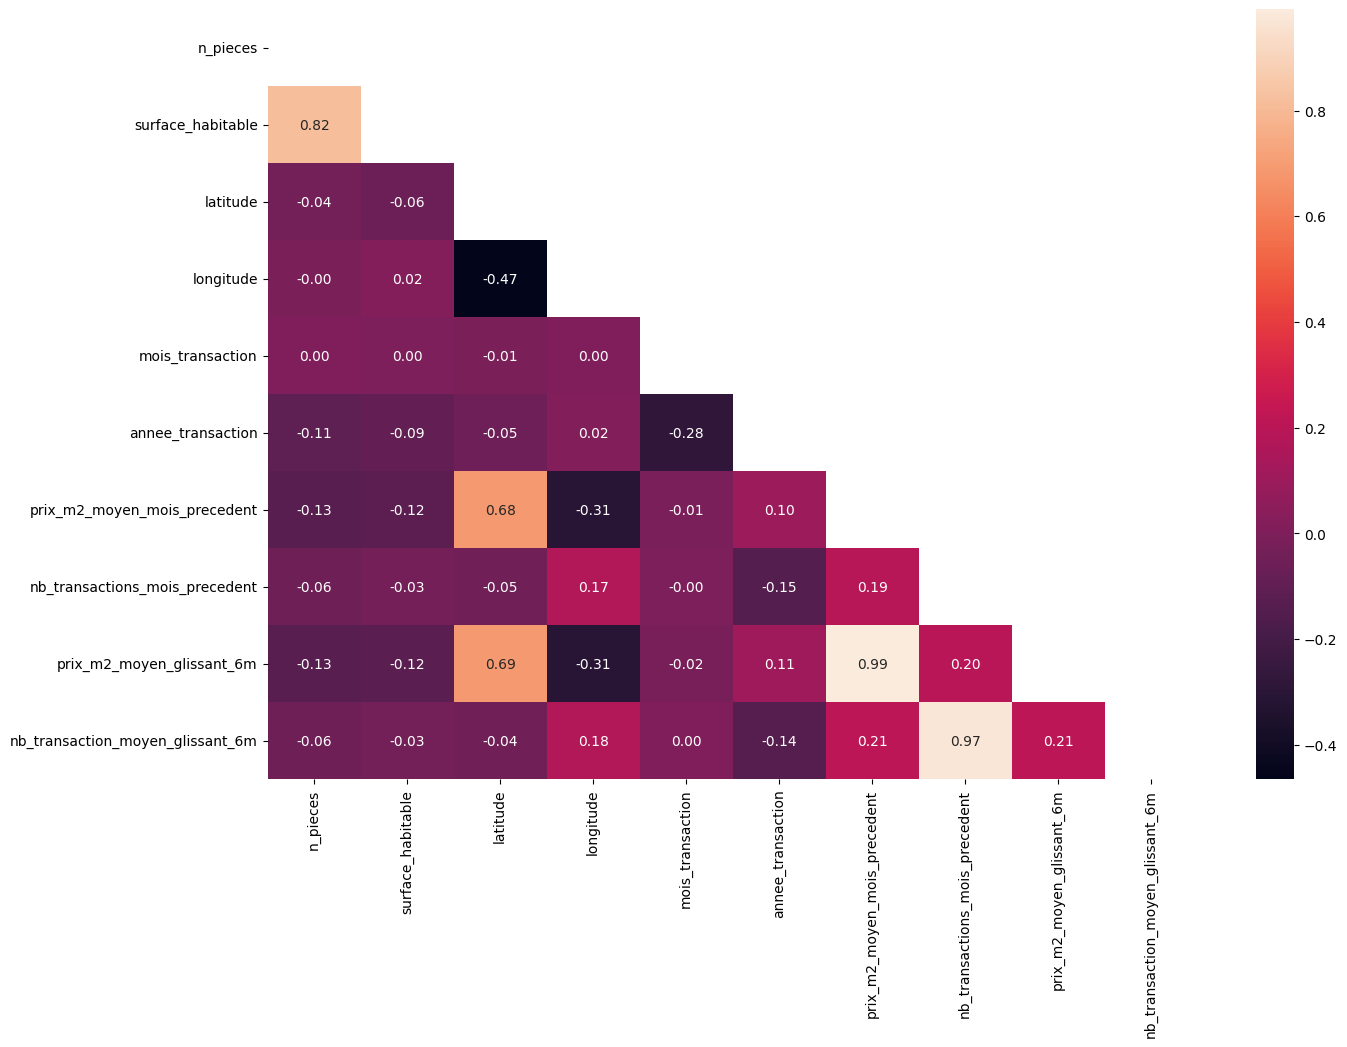

In [33]:
# matrice de corrélation

correlation_matrix= transactions[numerical_features].drop(REGRESSION_TARGET,axis=1).corr()
mask= np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt= '.2f')
plt.show()


## Analyse de la matrice de corrélation

On considère comme fortement corrélée les features ayant une corrélation > 0.7.

C'est le cas de :

- 'n_pieces' avec  'surface_habitable'
- 'nb_transactions_mois_precedent' avec 'nb_transaction_moyen_glissant_6'
- 'prix_m2_moyen_glissant' avec 'prix_m2_moyen_mois_precedent_6'

Ces corélations indiquent que le prix au m2 et le nombre de transactions évoluent peu sur 6 mois.
parmi les variables corrélée, on choisi de conserver la surface habitable et les features concernant le mois précédent.

## Conclusion

Au terme de ce notebook, nous avons établi un processus robuste de feature engineering visant à :

- **Recalculer les indicateurs**  
  Le prix au m² et le nombre de transactions sont désormais basés sur les données du mois précédent, garantissant ainsi une meilleure intégrité des informations et évitant le data leakage.

- **Intégrer une dimension temporelle**  
  La moyenne glissante sur 6 mois permet de capturer la stabilité et les tendances sous-jacentes des indicateurs immobiliers.

- **Enrichir le jeu de données avec une nouvelle feature**  
  La feature **"ville demandée"** offre une perspective supplémentaire en identifiant les villes à forte activité transactionnelle au sein du département.

- **Optimiser la sélection des features**  
  L'analyse de la matrice de corrélation a permis de mettre en lumière des redondances potentielles. Nous avons ainsi privilégié la surface habitable et les mesures mensuelles (mois précédent) pour une meilleure efficacité de nos modèles.

Ces étapes préparent le terrain pour l'implémentation de la fonction `feature_engineering.py` et l'intégration des transformations dans le pipeline global de traitement de données. Ce travail de préparation est essentiel pour garantir la qualité et la pertinence des analyses et modèles prédictifs ultérieurs.